In [63]:
%matplotlib inline
import sys

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy.random as rnd
from sklearn.preprocessing import StandardScaler

In [22]:
def dataset():
    rnd.seed(4)
    m = 200
    w1, w2 = 0.1, 0.3
    noise = 0.1

    angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(data[:100])
    X_test = scaler.transform(data[100:])
    
    return X_train, X_test

### Performing PCA with an Undercomplete Linear Autoencoder

In [9]:
n_inputs = 3 # 3D inputs
n_hidden = 2 # 2D codings
n_outputs = n_inputs

learning_rate = 0.01

In [10]:
X = tf.placeholder(tf.float32, shape=[None, n_inputs])

# By not adding any non-linear activations, it can perform PCA.
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

In [14]:
init = tf.global_variables_initializer()

X_train, X_test = dataset()

n_iterations = 1000
codings = hidden

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_train})
    codings_val = codings.eval(feed_dict={X: X_test})

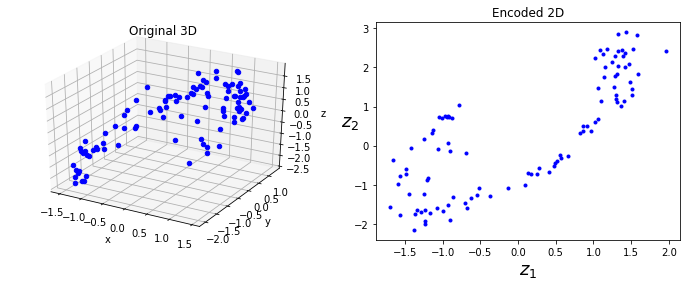

In [44]:
fig = plt.figure(figsize=(12, 4))

ax = fig.add_subplot(121, projection='3d')
for x, y, z in X_train:
    ax.scatter(x, y, z, c='b', marker='o')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('Original 3D')

plt.subplot(122)
plt.plot(codings_val[:,0], codings_val[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.title('Encoded 2D')
plt.show()

### Stacked Autoencoder with MNIST

In [46]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [77]:
n_inputs = 28 * 28 # MNIST img size
n_hidden1 = 300
n_hidden2 = 150 # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

In [70]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")

initializer = tf.contrib.layers.variance_scaling_initializer()
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
activation = tf.nn.elu

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])
weights4_init = initializer([n_hidden3, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")
weights4 = tf.Variable(weights4_init, dtype=tf.float32, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)

outputs = tf.add(tf.matmul(hidden3, weights4), biases4, name="outputs")
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)

# Training hidden layers separately helps improvoing performance
with tf.name_scope("phase1"):
    phase1_outputs = tf.matmul(hidden1, weights4) + biases4
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - X))
    phase1_reg_loss = regularizer(weights1) + regularizer(weights4)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)

with tf.name_scope("phase2"):
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1))
    phase2_reg_loss = regularizer(weights2) + regularizer(weights3)
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    train_vars = [weights2, biases2, weights3, biases3]
    
    # By passing train_vars to var_list argument for optimizer.minimize(),
    # it freezes other trainable variables.
    phase2_training_op = optimizer.minimize(phase2_loss, var_list=train_vars)

In [71]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase+1))
        
        # For Phase 2, hidden layer 1's output is always the same because it is frozen.
        # So caching it does help boost performance
        if phase == 1:
            hidden1_cache = hidden1.eval(feed_dict={X: mnist.train.images})
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                if phase == 1:
                    indices = rnd.permutation(mnist.train.num_examples)
                    hidden1_batch = hidden1_cache[indices[:batch_sizes[phase]]]
                    feed_dict = {hidden1: hidden1_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
                else:
                    X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                    sess.run(training_ops, feed_dict={X: X_batch})
            loss_train = reconstruction_losses[phase].eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE: ", loss_train)
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print("Test MSE: ", loss_test)
    saver.save(sess, 'tmp/15-ae.ckpt')

Training phase #1
0 %Train MSE:  0.0076553
1 Train MSE:  0.00748585
2 Train MSE:  0.00742019
39% Train MSE:  0.00785537
Training phase #2
0 Train MSE:  0.00217482
1 Train MSE:  0.00228312
2 Train MSE:  0.00236058
3 Train MSE:  0.00243198
Test MSE:  0.00974783


### Visualizing the Reconstructions

In [75]:
def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap='Greys', interpolation='nearest')
    plt.axis('off')

In [116]:
def show_reconstructed_digits(ckpt, n_test_digits = 2, noise_var = ""):
    X_test = mnist.test.images[:n_test_digits]

    tf.reset_default_graph()
    saver = tf.train.import_meta_graph(ckpt + '.meta')

    with tf.Session() as sess:
        saver.restore(sess, ckpt)
        X = tf.get_default_graph().get_tensor_by_name("X:0")
        var_list = []
        if noise_var:
            X_noisy = tf.get_default_graph().get_tensor_by_name(noise_var)
            var_list.append(X_noisy)
        outputs = tf.get_default_graph().get_tensor_by_name("outputs:0")
        var_list.append(outputs)
        evals = sess.run(var_list, feed_dict={X: X_test})
    
    cols = 3 if noise_var else 2
    for digit_index in range(n_test_digits):
        colidx = 1
        plt.subplot(n_test_digits, cols, digit_index * cols + colidx)
        plot_image(X_test[digit_index])
        colidx += 1
        if noise_var:
            plt.subplot(n_test_digits, cols, digit_index * cols + colidx)
            plot_image(evals[0][digit_index])
            colidx += 1
        plt.subplot(n_test_digits, cols, digit_index * cols + colidx)
        plot_image(evals[-1][digit_index])

INFO:tensorflow:Restoring parameters from tmp/15-ae.ckpt


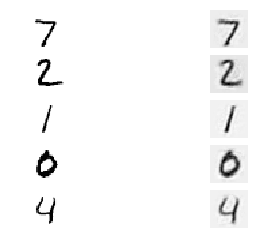

In [117]:
show_reconstructed_digits("tmp/15-ae.ckpt", 5)

### Visualizing Features

INFO:tensorflow:Restoring parameters from tmp/15-ae.ckpt


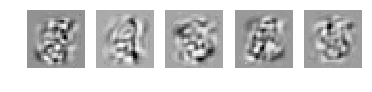

In [76]:
tf.reset_default_graph()

saver = tf.train.import_meta_graph('tmp/15-ae.ckpt.meta')

with tf.Session() as sess:
    saver.restore(sess, 'tmp/15-ae.ckpt')
    weights1 = tf.get_default_graph().get_tensor_by_name("weights1:0")
    weights1_val = weights1.eval()

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plot_image(weights1_val.T[i])

### Denoising Autoencoders

In [79]:
n_inputs = 28 * 28 # MNIST img size
n_hidden1 = 300
n_hidden2 = 150 # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

noise_level = 1.0

In [127]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
X_noisy = tf.identity(X + noise_level * tf.random_normal(tf.shape(X)), name="X_noisy")

hidden1 = tf.layers.dense(X_noisy, n_hidden1, activation=tf.nn.relu, name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")

outputs = tf.layers.dense(hidden3, n_outputs)
outputs = tf.identity(outputs, name="outputs")

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

In [128]:
n_epochs = 10
batch_size = 150

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE: ", loss_train)
        saver.save(sess, "tmp/15-denoise-ae.ckpt")

0 Train MSE:  0.0423216
1 Train MSE:  0.0429105
29% Train MSE:  0.0432666
3 Train MSE:  0.0402968
4 %Train MSE:  0.0434386
5 Train MSE:  0.0430209
6 Train MSE:  0.0417718
7 %Train MSE:  0.0408702
8 Train MSE:  0.043739
9 Train MSE:  0.0427067


INFO:tensorflow:Restoring parameters from tmp/15-denoise-ae.ckpt


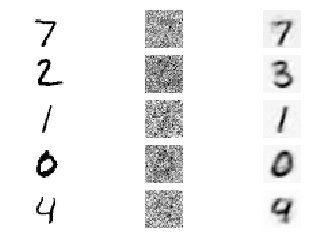

In [129]:
show_reconstructed_digits("tmp/15-denoise-ae.ckpt", n_test_digits=5, noise_var="X_noisy:0")

### Sparse Autoencoders

In [132]:
n_inputs = 28 * 28 # MNIST img size
n_hidden1 = 1000
n_outputs = n_inputs

learning_rate = 0.01

sparsity_target = 0.1
sparsity_weight = 0.2

In [130]:
def kl_divergence(p, q):
    return p * tf.log(p / q) + (1 - p) * tf.log((1 - p) / (1 - q))

In [144]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")

# To prevent kl_divergence returning NaN, 
# outputs of activation in hidden layer should be between 0 and 1.
# Sigmoid activation works for this purpose.
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid)

outputs = tf.layers.dense(hidden1, n_outputs)
outputs = tf.identity(outputs, name="outputs")

hidden1_mean = tf.reduce_mean(hidden1, axis=0) # batch mean
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden1_mean))
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE
loss = reconstruction_loss + sparsity_weight * sparsity_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

In [145]:
n_epochs = 100
batch_size = 1000

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    n_batches = mnist.train.num_examples // batch_size
    for epoch in range(n_epochs):
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        reconstruction_loss_val, sparsity_loss_val, loss_val = sess.run([reconstruction_loss, sparsity_loss, loss],
                                                                       feed_dict={X: X_batch})
        print("\r{}".format(epoch),
              "Train MSE: ", reconstruction_loss_val,
              "\tSparsity loss: ", sparsity_loss_val,
              "\tTotal Loss: ", loss_val)
        saver.save(sess, "tmp/15-sparse-ae.ckpt")

0 Train MSE:  0.133781 	Sparsity loss:  0.263425 	Total Loss:  0.186466
1 Train MSE:  0.0598119 	Sparsity loss:  0.0726168 	Total Loss:  0.0743353
2 Train MSE:  0.0542771 	Sparsity loss:  0.0749669 	Total Loss:  0.0692704
3 Train MSE:  0.0479994 	Sparsity loss:  0.104694 	Total Loss:  0.0689381
4 Train MSE:  0.0450256 	Sparsity loss:  0.189715 	Total Loss:  0.0829686
5 Train MSE:  0.0423453 	Sparsity loss:  0.127224 	Total Loss:  0.06779
6 Train MSE:  0.0386192 	Sparsity loss:  0.209966 	Total Loss:  0.0806123
7 Train MSE:  0.0348252 	Sparsity loss:  0.0104594 	Total Loss:  0.0369171
8 Train MSE:  0.0323245 	Sparsity loss:  0.0858374 	Total Loss:  0.0494919
9 Train MSE:  0.0284414 	Sparsity loss:  0.0428303 	Total Loss:  0.0370075
10 Train MSE:  0.0273732 	Sparsity loss:  0.0158446 	Total Loss:  0.0305421
11 Train MSE:  0.025128 	Sparsity loss:  0.0710316 	Total Loss:  0.0393343
12 Train MSE:  0.0229033 	Sparsity loss:  0.270218 	Total Loss:  0.0769469
13 Train MSE:  0.0214889 	Sparsit

INFO:tensorflow:Restoring parameters from tmp/15-sparse-ae.ckpt


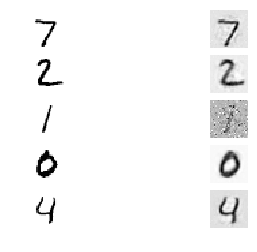

In [147]:
show_reconstructed_digits("tmp/15-sparse-ae.ckpt", n_test_digits=5)

### Variational Autoencoder

In [148]:
n_inputs = 28 * 28 # MNIST img size
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20 # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.001

In [167]:
from functools import partial

tf.reset_default_graph()

initializer = tf.contrib.layers.variance_scaling_initializer()
my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.relu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs], name="X")
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_gamma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_gamma), dtype=tf.float32)
hidden3 = tf.identity(hidden3_mean + tf.exp(0.5 * hidden3_gamma) * noise, name="hidden3")
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.identity(tf.sigmoid(logits), name="outputs")

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)
latent_loss = 0.5 * tf.reduce_sum(tf.exp(hidden3_gamma) + 
                                  tf.square(hidden3_mean) - 1 - hidden3_gamma)
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss, name="training_op")

In [168]:
n_epochs = 50
batch_size = 150

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict = {X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run(
            [loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), 
              "Train total loss: ", loss_val, 
              "\tReconstruction loss: ", reconstruction_loss_val, 
              "\tLatent loss: ", latent_loss_val)
        saver.save(sess, "tmp/15-var-ae.ckpt")
        

0 Train total loss:  18496.8 	Reconstruction loss:  15023.2 	Latent loss:  3473.65
1 Train total loss:  17367.4 	Reconstruction loss:  13701.1 	Latent loss:  3666.27
2 Train total loss:  16368.8 	Reconstruction loss:  12626.8 	Latent loss:  3742.01
3 Train total loss:  16732.4 	Reconstruction loss:  12850.5 	Latent loss:  3881.95
4 Train total loss:  15872.8 	Reconstruction loss:  12291.3 	Latent loss:  3581.46
5 Train total loss:  15937.2 	Reconstruction loss:  12313.7 	Latent loss:  3623.54
6 Train total loss:  16348.0 	Reconstruction loss:  12573.1 	Latent loss:  3774.89
7 Train total loss:  15728.5 	Reconstruction loss:  12035.5 	Latent loss:  3693.03
8 Train total loss:  15496.5 	Reconstruction loss:  11833.9 	Latent loss:  3662.59
9 Train total loss:  15752.5 	Reconstruction loss:  12110.1 	Latent loss:  3642.4
10 Train total loss:  15022.9 	Reconstruction loss:  11425.9 	Latent loss:  3597.09
11 Train total loss:  15168.9 	Reconstruction loss:  11483.1 	Latent loss:  3685.81
12 

### Generate Digits

In [171]:
n_digits = 60
n_epochs = 50
batch_size = 150

tf.reset_default_graph()
saver = tf.train.import_meta_graph('tmp/15-var-ae.ckpt.meta')

with tf.Session() as sess:
    saver.restore(sess, 'tmp/15-var-ae.ckpt')
    
    X = tf.get_default_graph().get_tensor_by_name("X:0")
    hidden3 = tf.get_default_graph().get_tensor_by_name("hidden3:0")
    outputs = tf.get_default_graph().get_tensor_by_name("outputs:0")
    training_op = tf.get_default_graph().get_operation_by_name("training_op")
    
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict = {X: X_batch})
            
    codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

INFO:tensorflow:Restoring parameters from tmp/15-var-ae.ckpt


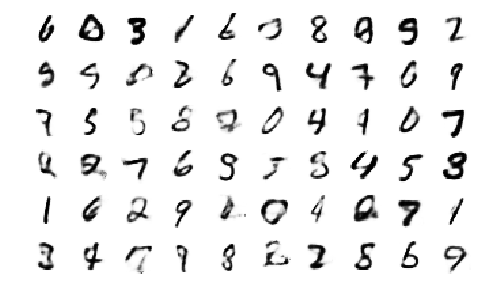

In [172]:
plt.figure(figsize=(8,50))
for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration+1)
    plot_image(outputs_val[iteration])